In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from ext.lab2im import utils
from ext.lab2im.edit_volumes import align_volume_to_ref
from SynthSeg.brain_generator import read_tfrecords
import tensorflow as tf

2024-03-18 12:56:00.230060: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 12:56:00.230086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 12:56:00.230093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 12:56:00.236155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Peek into data

Data downloaded from https://datashare.mpcdf.mpg.de/f/348054516

In [2]:
image_nii = nib.load("t1w_pdw_validation_pair/t1_pdw_scaled_256.nii")

In [3]:
image = image_nii.get_fdata()
image.shape

(256, 256, 256, 2)

In [4]:
labels = nib.load("t1w_pdw_validation_pair/label_256.nii").get_fdata()

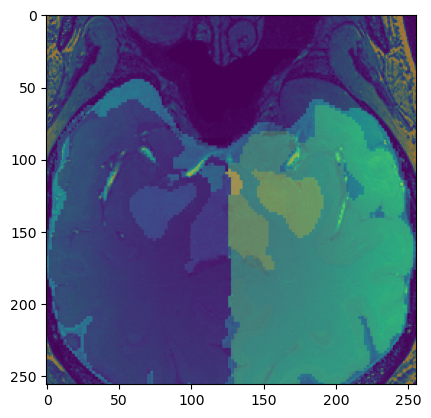

In [5]:
plt.imshow(image[100,..., 0], alpha=1.0)
plt.imshow(labels[100, ...], alpha=0.5)

## Align CBS volume to train volumes

Train images have a reference aff matrix of np.eye(4) ...

In [12]:
image, _, aff, n_dims, n_channels, h, im_res = utils.get_volume_info("./t1w_pdw_validation_pair/t1_pdw_scaled_256.nii", return_volume=True)

In [13]:
image_aligned = align_volume_to_ref(image, aff, aff_ref=np.eye(4), n_dims=3)

In [14]:
labels_aligned = align_volume_to_ref(labels, aff, aff_ref=np.eye(4), n_dims=3)

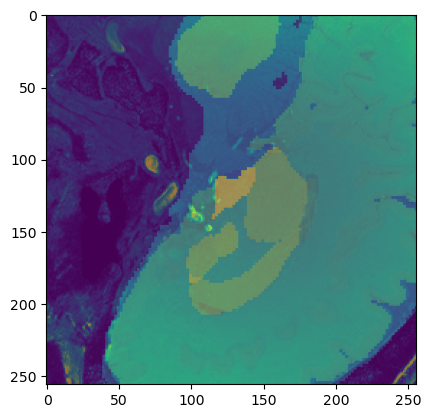

In [40]:
plt.imshow(image_aligned[150,:,:, 0], alpha=1.0)
plt.imshow(labels_aligned[150,:,:], alpha=0.5)

In [27]:
train_ds = read_tfrecords(["train_tfrecords/000000_512.tfrecord"])
train_it = iter(train_ds)

In [28]:
train_img, _ = next(train_it)

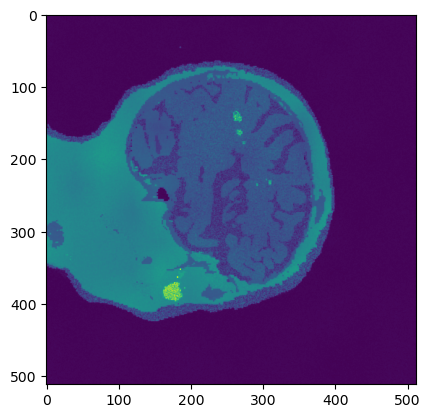

In [38]:
plt.imshow(train_img[180, :, :, 0])

## Map labels

In [17]:
class LabelMapping:
    def __init__(self, cfg_path):
        cfg_path = Path(cfg_path)
        with cfg_path.open() as file:
            cfg = yaml.safe_load(file)
        output_labels = cfg["output_labels"]
        self._mapping = utils.get_mapping_lut(np.unique(output_labels))

    def lab2idx(self, label: int) -> int:
        try:
            return self._mapping[label]
        except IndexError:
            return 0

    def idx2lab(self, idx: int):
        return np.nonzero(self._mapping == idx)[0][0]

In [18]:
label_mapping = LabelMapping("./generator.yml")

In [19]:
labels_aligned = labels_aligned.astype(np.int32)
np.unique(labels_aligned), len(np.unique(labels_aligned))

(array([ 0,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24,
        26, 28, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60],
       dtype=int32),
 33)

In [20]:
labels_mapped = np.array(list(map(label_mapping.lab2idx, labels_aligned.flatten()))).reshape(labels_aligned.shape)

In [21]:
np.unique(labels_mapped)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int32)

## Create TFRecords

In [24]:
compression_type = None
file = "./t1w_pdw_validation_pair.tfrecord"

with tf.io.TFRecordWriter(
    str(file), options=tf.io.TFRecordOptions(compression_type=compression_type)
) as writer:
    # create tf example
    features = {
        "image": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[tf.io.serialize_tensor(image_aligned.astype(np.float32)).numpy()]
            )
        ),
        "labels": tf.train.Feature(
            bytes_list=tf.train.BytesList(
                value=[tf.io.serialize_tensor(labels_mapped).numpy()]
            )
        ),
    }  

    example = tf.train.Example(features=tf.train.Features(feature=features))

    # write to file
    writer.write(example.SerializeToString())

In [41]:
# sanity check
file = "/home/david/Downloads/t1w_pdw_validation_pair.tfrecord"
ds = read_tfrecords([file])
img, lab = next(iter(ds))
np.allclose(img.numpy(), image_aligned), np.allclose(lab.numpy(), labels_mapped)

(True, True)

Output file uploaded to https://datashare.mpcdf.mpg.de/f/348054516

# ... Playground

In [5]:
valid_nii = nib.load("./t1w_pdw_validation_pair/t1_pdw_scaled_256.nii")
valid_img = valid_nii.get_fdata()
valid_img.shape

(256, 256, 256, 2)

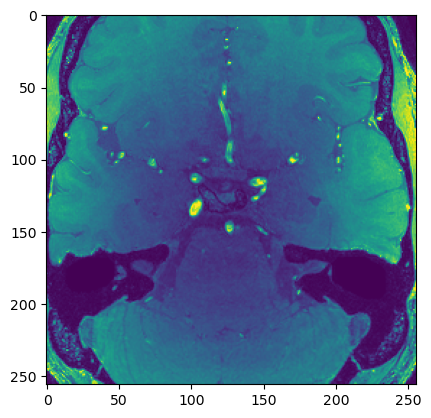

In [83]:
plt.imshow(valid_img[:,100,:, 0])

In [60]:
from ext.lab2im.utils import get_volume_info
from ext.lab2im.edit_volumes import align_volume_to_ref

In [140]:
im, _, aff, n_dims, n_channels, h, im_res = get_volume_info("./t1w_pdw_validation_pair/t1_pdw_scaled_256.nii", return_volume=True)
#im, _, aff, n_dims, n_channels, h, im_res = get_volume_info("./T1w_rescaled_for_segmentation.nii", return_volume=True)

In [141]:
aff

array([[  0.        ,   0.        ,   1.        , -87.5       ],
       [ -0.86602539,  -0.49999997,   0.        , 189.36741638],
       [ -0.49999997,   0.86602539,   0.        , -74.01698303],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

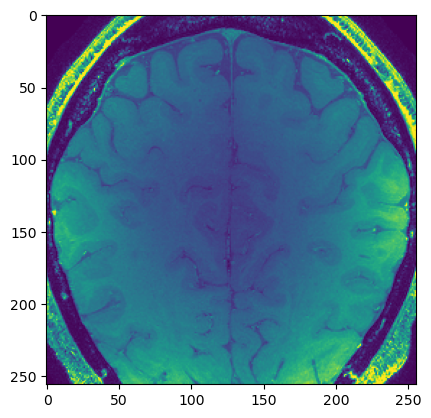

In [143]:
plt.imshow(im[:, 220, :, 0])

In [144]:
im2 = align_volume_to_ref(im, aff, aff_ref=np.eye(4), n_dims=3, return_copy=False)

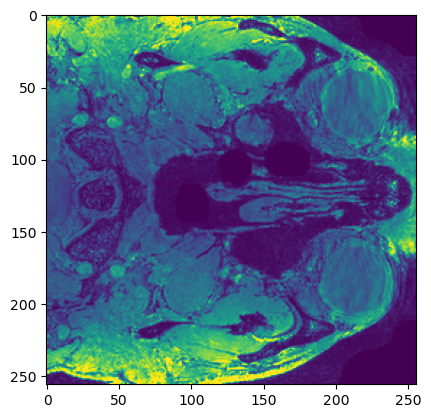

In [147]:
plt.imshow(im2[:,:,20,0])

In [56]:
train_ds = read_tfrecords(["train_tfrecords/000000_512.tfrecord"])
train_it = iter(train_ds)

In [57]:
train_img, _ = next(train_it)

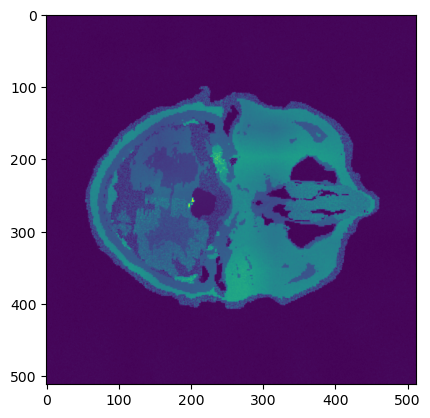

In [139]:
plt.imshow(train_img[:, :, 150, 0])

In [58]:
from SynthSeg.brain_generator import BrainGenerator
BrainGenerator.tfrecord_to_brain?

Signature: BrainGenerator.tfrecord_to_brain(self, file: Union[str, pathlib.Path]) -> Tuple[numpy.ndarray, numpy.ndarray]
Docstring:
Read a tfrecord file and return the brain images and labels in the `self.generate_brain` format.

Args:
    file: Path to the TFRecord file.

Returns:
    Brain images and labels in the `self.generate_brain` format.
File:      ~/mpcdf/cbs/segmentation/SynthSeg/SynthSeg/brain_generator.py
Type:      function

In [28]:
img_nii = nib.load("../01_from_datashare/T1w.nii")
img = img_nii.get_fdata()

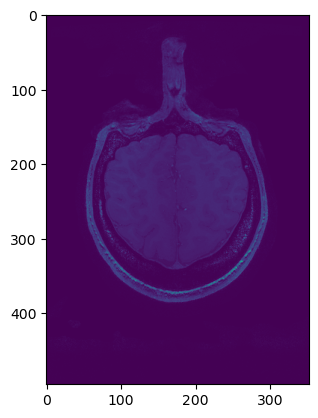

In [34]:
plt.imshow(img[100,...])

In [ ]:
img.max()

In [ ]:
plt.hist(crop(test_vol).flatten(), bins=100);

In [40]:
test_vol = nib.load("T1w_rescaled_for_segmentation.nii").get_fdata()
test_vol.shape

(434, 496, 352)

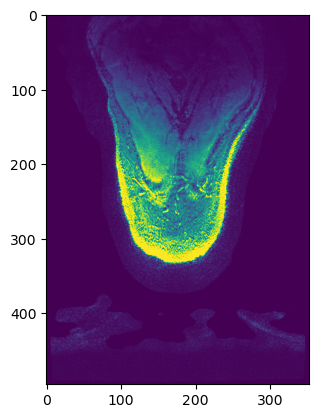

In [56]:
plt.imshow(test_vol[400, :, :])

In [ ]:
def crop(volume):
    max_idxs = []
    for dim in volume.shape:
        max_idxs.append(dim - 256)
        
    slices = []
    for max_idx in max_idxs:
        rand_int = np.random.randint(0, max_idx)
        slices.append(slice(rand_int, rand_int + 256))

    return volume[slices[0], slices[1], slices[2]]

In [ ]:
iterator = iter(train_ds)

In [ ]:
train_img, label_img = next(iterator)

In [ ]:
train_img.shape, train_img[..., 0].numpy().sum()

In [ ]:
plt.hist(train_img.numpy()[..., 0].flatten(), bins=100);
plt.hist(img[...,0].flatten(), bins=100, alpha=0.3);

In [ ]:
from SynthSeg.brain_generator import read_tfrecords

In [ ]:
train_ds = read_tfrecords(["./train_tfrecords/000000.tfrecord"])

In [ ]:
plt.imshow(seg[100,...], alpha=0.5)
plt.imshow(img_rs[100, ...], alpha=0.5)

In [ ]:
img_rs_nii = nib.load("../t1w_pdw_config/T1w_rescaled_for_segmentation.nii")
img_rs = img_rs_nii.get_fdata()
img_rs.max()

Run segmentation as described in `approach.ipynb`

In [ ]:
seg_nii = nib.load("T1w_segmentations2.nii")
seg = seg_nii.get_fdata()

In [ ]:
seg_nii.header.get_data_shape()

In [ ]:
labels = np.unique(seg)
labels, len(labels)

In [ ]:
img_rs.shape, seg.shape

In [ ]:
from SynthSeg.analysis.contrast_analysis import clip_and_rescale_nifti

root_dir = "/home/david/mpcdf/cbs/segmentation/SynthSeg"
input_file = f"{root_dir}/data/cbs/01_from_datashare/T1w.nii"
output_file = f"{root_dir}/data/cbs/t1w_pdw_config/T1w_rescaled_for_segmentation.nii"

clip_and_rescale_nifti(
    nifti_file=input_file,
    out_file=output_file,
    min_clip=0.0,
    max_clip=2000,
    min_out=0.0,
    max_out=1.0
)